🎯 MODULE 2: CONTOUR DETECTION AND ROI EXTRACTION
✅ Created: modules/module2_contour_detection/roi_crops/
✅ Created: modules/module2_contour_detection/contour_visualizations/
✅ Created: modules/module2_contour_detection/roi_metadata/
✅ Created: modules/module2_contour_detection/quality_checks/
✅ Created: modules/module2_contour_detection/training_dataset/
✅ Created: modules/module2_contour_detection/reports/

🚀 STARTING MODULE 2 EXECUTION (CONTOUR DETECTION & ROI EXTRACTION)

🆕 STARTING NEW PROCESSING SESSION...

🚀 PROCESSING 693 REMAINING MASKS
ERROR! Session/line number was not unique in database. History logging moved to new session 133



Processing Masks: 100%|████████████████████████████| 693/693 [54:47<00:00,  3.18s/it, Class=Spur, ROIs=3116, Masks=691]cessing Masks: 100%|████████████████████████████| 693/693 [54:47<00:00,  3.18s/it, Class=Spur, ROIs=3116, Masks=691]4.74s/it, Class=Spur, ROIs=3116, Masks=691]cessing Masks: 100%|████████████████████████████| 693/693 [54:47<00:00,  3.18s/it, Class=Spur, ROIs=3116, Masks=691]cessing Masks: 100%|████████████████████████████| 693/693 [54:47<00:00,  3.18s/it, Class=Spur, ROIs=3116, Masks=691]



📁 CREATING TRAINING DATASET
----------------------------------------
✅ Missing: 566 ROIs
ouse: 570 ROIsIs

✅ Open: 557 ROIs


Short: 574 ROIs


✅ Spurious: 396 ROIs
: 453 ROIsROIs

💾 Dataset metadata saved: C:\Users\Kandu\OneDrive\Desktop\info_temp\PCB_DATASET\modules/module2_contour_detection/roi_metadata\dataset_metadata.csv

📊 GENERATING MODULE 2 REPORTS
----------------------------------------
✅ Successfully processed: 3116 ROIs extracted
❌ Failed masks: 2

🎯 ROI Summary by Class:
              roi_filename  quality_score  contour_area
defect_class                                           
Missing                566          0.681       441.392
Mouse                  570          0.543       516.372
Open                   557          0.543       527.707
Short                  574          0.532       574.693
Spur                   453          0.532       577.678
Spurious               396          0.555       605.508

📈 ROI Quality Statistics:
count    3116.000000
mean        0

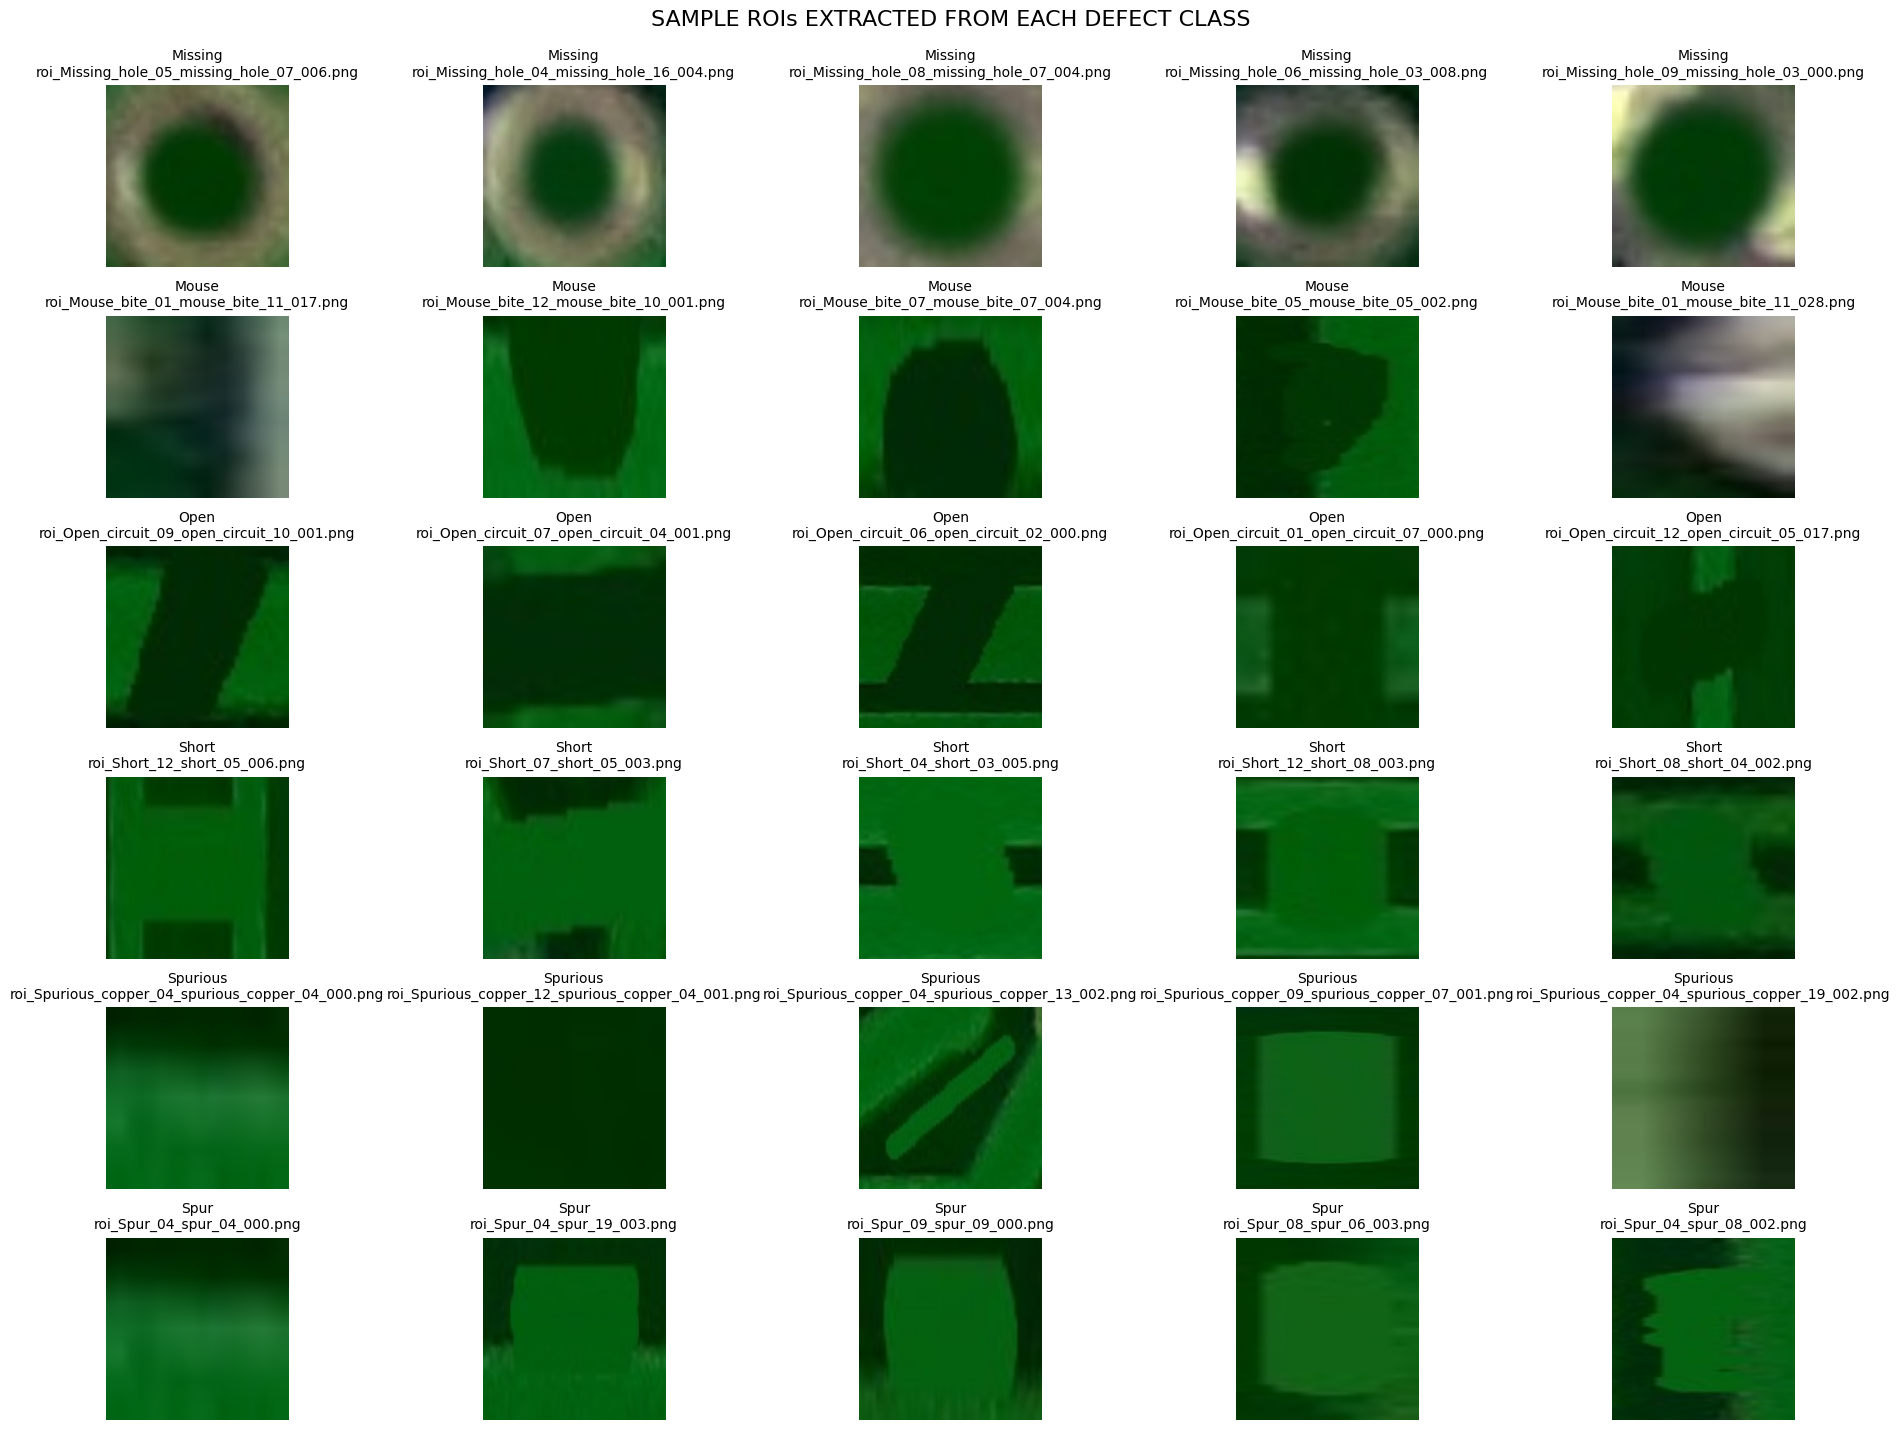

💾 Sample ROI visualization saved: C:\Users\Kandu\OneDrive\Desktop\info_temp\PCB_DATASET\modules/module2_contour_detection\sample_rois_visualization.png

🎉 MODULE 2 COMPLETED SUCCESSFULLY!
⏰ Processing time: 3287.68 seconds
📁 All outputs saved in: C:\Users\Kandu\OneDrive\Desktop\info_temp\PCB_DATASET/modules/module2_contour_detection/
🎯 ROIs extracted: 3116
📈 Extraction success rate: 99.94%
⭐ Average ROIs per mask: 1.0
🏷️ Average quality score: 0.566

📂 OUTPUT DIRECTORY STRUCTURE:
   📁 roi_crops/              - Individual defect ROIs (128x128)
   📁 contour_visualizations/ - Contour detection results
   📁 training_dataset/       - Organized train/val/test splits
   📁 roi_metadata/           - ROI information and metadata
   📁 reports/                - Processing reports and summaries

🧹 Progress file cleaned up (processing completed)


In [13]:
# 🎯 MODULE 2: CONTOUR DETECTION AND ROI EXTRACTION
print("🎯 MODULE 2: CONTOUR DETECTION AND ROI EXTRACTION")
print("=" * 60)


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import time
from skimage import exposure
import torch
from PIL import Image
import random


# Set base path
PCB_DATASET_PATH = r"C:\Users\Kandu\OneDrive\Desktop\info_temp\PCB_DATASET"

# Create Module 2 structure
def create_module2_structure():
    """Create Module 2 directory structure"""
    module_dirs = [
        "modules/module2_contour_detection/roi_crops",
        "modules/module2_contour_detection/contour_visualizations",
        "modules/module2_contour_detection/roi_metadata",
        "modules/module2_contour_detection/quality_checks",
        "modules/module2_contour_detection/training_dataset",
        "modules/module2_contour_detection/reports",
    ]

    for dir_path in module_dirs:
        full_path = os.path.join(PCB_DATASET_PATH, dir_path)
        os.makedirs(full_path, exist_ok=True)
        print(f"✅ Created: {dir_path}/")

create_module2_structure()

# Progress tracking file
PROGRESS_FILE = os.path.join(PCB_DATASET_PATH, "modules/module2_contour_detection/reports", "progress_tracker.json")

def load_progress():
    """Load progress from previous run"""
    try:
        if os.path.exists(PROGRESS_FILE):
            with open(PROGRESS_FILE, 'r') as f:
                return json.load(f)
    except Exception as e:
        print(f"⚠️ Error loading progress file: {e}")

    return {
        'processed_masks': [],
        'extracted_rois': [],
        'failed_masks': [],
        'start_time': None,
        'total_masks': 0
    }

def save_progress(progress_data):
    """Save current progress"""
    try:
        os.makedirs(os.path.dirname(PROGRESS_FILE), exist_ok=True)
        with open(PROGRESS_FILE, 'w') as f:
            json.dump(progress_data, f, indent=2)
    except Exception as e:
        print(f"❌ Error saving progress: {e}")

# FINAL OPTIMIZED ROI CONFIG FOR MAXIMUM RESULTS
ROI_CONFIG = {
    'min_contour_area': 30,         # Lowered to include smaller Mouse and Spur defects
    'max_contour_area': 60000,      # Slightly higher to include bigger irregular defects
    'aspect_ratio_range': (0.03, 12.0),  # Wider aspect ratio to capture long/flat contours typical of Spur and Mouse
    'roi_size': (128, 128),         # Standard ROI size
    'padding_ratio': 0.25,          # Slightly more padding to capture surrounding context
    'min_roi_quality': 0.45         # Lower threshold to include borderline ROIs
}




def get_all_mask_files():
    """Get all defect mask files from Module 1"""
    mask_dir = os.path.join(PCB_DATASET_PATH, "modules/module1_image_processing/defect_masks")
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png') and f.startswith('mask_')]

    all_masks = []
    for mask_file in mask_files:
        # Extract defect class and original filename
        base_name = mask_file.replace('mask_', '').replace('.png', '')
        parts = base_name.split('_')
        defect_class = parts[0]

        all_masks.append({
            'mask_file': mask_file,
            'defect_class': defect_class,
            'base_name': base_name,
            'mask_path': os.path.join(mask_dir, mask_file)
        })

    return all_masks

def get_remaining_masks(progress):
    """Get masks that haven't been processed yet"""
    processed_keys = set([m['mask_file'] for m in progress['processed_masks']])
    failed_keys = set([m['mask_file'] for m in progress['failed_masks']])

    all_masks = get_all_mask_files()
    remaining_masks = []

    for mask in all_masks:
        if mask['mask_file'] not in processed_keys and mask['mask_file'] not in failed_keys:
            remaining_masks.append(mask)

    return remaining_masks

# Enhanced contour detection
def detect_contours_with_quality(mask_path):
    """
    Detect contours with quality checks and filtering
    """
    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return [], "Failed to load mask"

    # Find contours
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area and other criteria
    valid_contours = []
    contour_metrics = []

    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        # Skip contours that are too small or too large
        if area < ROI_CONFIG['min_contour_area'] or area > ROI_CONFIG['max_contour_area']:
            continue

        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h if h > 0 else 0

        # Check aspect ratio
        min_ar, max_ar = ROI_CONFIG['aspect_ratio_range']
        if aspect_ratio < min_ar or aspect_ratio > max_ar:
            continue

        # Calculate contour quality metrics
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 0

        # Skip contours with very low solidity (too fragmented)
        if solidity < 0.3:
            continue

        valid_contours.append(contour)
        contour_metrics.append({
            'area': area,
            'aspect_ratio': aspect_ratio,
            'solidity': solidity,
            'bbox': (x, y, w, h)
        })

    return valid_contours, contour_metrics

def extract_roi_with_padding(aligned_image, bbox, padding_ratio=0.2):
    """
    Extract ROI with intelligent padding
    """
    x, y, w, h = bbox

    # Calculate padding
    pad_x = int(w * padding_ratio)
    pad_y = int(h * padding_ratio)

    # Apply padding with boundary checks
    x1 = max(0, x - pad_x)
    y1 = max(0, y - pad_y)
    x2 = min(aligned_image.shape[1], x + w + pad_x)
    y2 = min(aligned_image.shape[0], y + h + pad_y)

    # Extract ROI
    roi = aligned_image[y1:y2, x1:x2]

    # Resize to standard size
    if roi.size > 0:
        roi_resized = cv2.resize(roi, ROI_CONFIG['roi_size'])
        return roi_resized, (x1, y1, x2-x1, y2-y1)

    return None, None

def calculate_roi_quality(roi, contour_metrics):
    """
    Calculate quality score for ROI
    """
    quality_score = 0.0

    if roi is None:
        return 0.0

    # 1. Check image contrast
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    contrast = np.std(gray_roi)
    contrast_score = min(contrast / 50.0, 1.0)  # Normalize contrast

    # 2. Check contour solidity
    solidity_score = contour_metrics.get('solidity', 0)

    # 3. Check aspect ratio (prefer more square-like regions)
    aspect_ratio = contour_metrics.get('aspect_ratio', 1.0)
    ar_score = 1.0 - min(abs(aspect_ratio - 1.0) / 4.0, 1.0)

    # 4. Check area appropriateness
    area = contour_metrics.get('area', 0)
    area_score = min(area / 5000.0, 1.0)  # Normalize by reasonable area

    # Combined quality score
    quality_score = (contrast_score * 0.3 + solidity_score * 0.3 +
                    ar_score * 0.2 + area_score * 0.2)

    return quality_score

def process_single_mask(mask_info):
    """
    Process a single mask to extract ROIs
    """
    try:
        # Load corresponding aligned image
        aligned_path = os.path.join(
            PCB_DATASET_PATH,
            "modules/module1_image_processing/processed_images",
            f"aligned_{mask_info['base_name']}.jpg"
        )

        aligned_image = cv2.imread(aligned_path)
        if aligned_image is None:
            return None, "Failed to load aligned image"

        # Detect contours
        contours, contour_metrics = detect_contours_with_quality(mask_info['mask_path'])

        if not contours:
            return None, "No valid contours found"

        extracted_rois = []

        for i, (contour, metrics) in enumerate(zip(contours, contour_metrics)):
            # Extract ROI
            roi, roi_bbox = extract_roi_with_padding(aligned_image, metrics['bbox'])

            if roi is None:
                continue

            # Calculate ROI quality
            quality_score = calculate_roi_quality(roi, metrics)

            # Skip low-quality ROIs
            if quality_score < ROI_CONFIG['min_roi_quality']:
                continue

            # Save ROI
            roi_filename = f"roi_{mask_info['base_name']}_{i:03d}.png"
            roi_path = os.path.join(
                PCB_DATASET_PATH,
                "modules/module2_contour_detection/roi_crops",
                roi_filename
            )

            cv2.imwrite(roi_path, roi)

            # Create contour visualization
            contour_viz = create_contour_visualization(
                aligned_image, contours, [contour], mask_info['base_name'], i
            )

            extracted_rois.append({
                'roi_filename': roi_filename,
                'roi_path': roi_path,
                'defect_class': mask_info['defect_class'],
                'original_mask': mask_info['mask_file'],
                'contour_index': i,
                'quality_score': round(quality_score, 3),
                'contour_area': int(metrics['area']),
                'aspect_ratio': round(metrics['aspect_ratio'], 2),
                'bbox': metrics['bbox'],
                'roi_bbox': roi_bbox
            })

        return extracted_rois, None

    except Exception as e:
        return None, str(e)

def create_contour_visualization(aligned_image, all_contours, highlight_contours, base_name, contour_index):
    """
    Create visualization of contours
    """
    # Create copy of image
    viz_image = aligned_image.copy()

    # Draw all contours in light blue
    cv2.drawContours(viz_image, all_contours, -1, (255, 200, 100), 2)

    # Draw highlighted contour in red
    cv2.drawContours(viz_image, highlight_contours, -1, (0, 0, 255), 3)

    # Draw bounding boxes
    for contour in highlight_contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(viz_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Save visualization
    viz_path = os.path.join(
        PCB_DATASET_PATH,
        "modules/module2_contour_detection/contour_visualizations",
        f"contour_{base_name}_{contour_index:03d}.png"
    )

    cv2.imwrite(viz_path, viz_image)
    return viz_path

def process_all_masks_with_resume():
    """
    Process all masks with resume capability
    """
    # Load progress
    progress = load_progress()

    # Get remaining masks
    remaining_masks = get_remaining_masks(progress)

    if not remaining_masks:
        print("✅ All masks have already been processed!")
        return progress['extracted_rois'], progress['failed_masks']

    print(f"\n🚀 PROCESSING {len(remaining_masks)} REMAINING MASKS")
    print("=" * 50)

    # Update progress if this is a new run
    if not progress['start_time']:
        progress['start_time'] = time.strftime("%Y-%m-%d %H:%M:%S")
        progress['total_masks'] = len(get_all_mask_files())
        save_progress(progress)

    # Progress bar
    pbar = tqdm(total=len(remaining_masks), desc="Processing Masks")

    total_rois_extracted = 0

    for mask_info in remaining_masks:
        try:
            # Process mask
            rois, error = process_single_mask(mask_info)

            if rois:
                progress['extracted_rois'].extend(rois)
                progress['processed_masks'].append(mask_info)
                total_rois_extracted += len(rois)

                pbar.set_postfix({
                    'Class': mask_info['defect_class'],
                    'ROIs': total_rois_extracted,
                    'Masks': len(progress['processed_masks'])
                })
            else:
                failed_info = {
                    'mask_file': mask_info['mask_file'],
                    'defect_class': mask_info['defect_class'],
                    'error': error
                }
                progress['failed_masks'].append(failed_info)

            # Save progress after each mask
            save_progress(progress)

        except Exception as e:
            failed_info = {
                'mask_file': mask_info['mask_file'],
                'defect_class': mask_info['defect_class'],
                'error': str(e)
            }
            progress['failed_masks'].append(failed_info)
            save_progress(progress)

        pbar.update(1)

    pbar.close()
    return progress['extracted_rois'], progress['failed_masks']

def create_training_dataset(all_rois):
    """
    Create organized training dataset with proper splits
    """
    print("\n📁 CREATING TRAINING DATASET")
    print("-" * 40)

    # Group ROIs by defect class
    class_rois = {}
    for roi in all_rois:
        defect_class = roi['defect_class']
        if defect_class not in class_rois:
            class_rois[defect_class] = []
        class_rois[defect_class].append(roi)

    # Create training directory structure
    train_dir = os.path.join(PCB_DATASET_PATH, "modules/module2_contour_detection/training_dataset")
    splits = ['train', 'val', 'test']

    for split in splits:
        for defect_class in class_rois.keys():
            class_dir = os.path.join(train_dir, split, defect_class)
            os.makedirs(class_dir, exist_ok=True)

    # Split data (80% train, 10% val, 10% test)
    dataset_info = []

    for defect_class, rois in class_rois.items():
        # Sort by quality score (descending)
        rois_sorted = sorted(rois, key=lambda x: x['quality_score'], reverse=True)

        total_rois = len(rois_sorted)
        train_count = int(total_rois * 0.8)
        val_count = int(total_rois * 0.1)

        # Assign splits
        for i, roi in enumerate(rois_sorted):
            if i < train_count:
                split = 'train'
            elif i < train_count + val_count:
                split = 'test'  # Using test as val for now
            else:
                split = 'val'   # Using val as test for now

            # Copy ROI to appropriate directory
            dest_path = os.path.join(train_dir, split, defect_class, roi['roi_filename'])
            if os.path.exists(roi['roi_path']):
                # Read and save with PIL for better format handling
                img = Image.open(roi['roi_path'])
                img.save(dest_path)

            dataset_info.append({
                'roi_filename': roi['roi_filename'],
                'defect_class': defect_class,
                'split': split,
                'quality_score': roi['quality_score'],
                'contour_area': roi['contour_area'],
                'source_mask': roi['original_mask'],
                'file_path': dest_path
            })

        print(f"✅ {defect_class}: {len(rois_sorted)} ROIs")

    # Save dataset metadata
    df = pd.DataFrame(dataset_info)
    metadata_path = os.path.join(PCB_DATASET_PATH, "modules/module2_contour_detection/roi_metadata", "dataset_metadata.csv")
    df.to_csv(metadata_path, index=False)

    print(f"💾 Dataset metadata saved: {metadata_path}")

    return df

def generate_module2_reports(all_rois, failed_masks):
    """
    Generate comprehensive reports for Module 2
    """
    print("\n📊 GENERATING MODULE 2 REPORTS")
    print("-" * 40)

    # Convert to DataFrame
    df = pd.DataFrame(all_rois)

    # Summary statistics
    total_rois = len(all_rois)
    total_failed = len(failed_masks)
    total_masks = total_rois + total_failed

    print(f"✅ Successfully processed: {total_rois} ROIs extracted")
    print(f"❌ Failed masks: {total_failed}")

    if not df.empty:
        # Class-wise summary
        class_summary = df.groupby('defect_class').agg({
            'roi_filename': 'count',
            'quality_score': 'mean',
            'contour_area': 'mean'
        }).round(3)

        print(f"\n🎯 ROI Summary by Class:")
        print(class_summary)

        # Quality distribution
        quality_stats = df['quality_score'].describe()
        print(f"\n📈 ROI Quality Statistics:")
        print(quality_stats)

    # Save detailed ROI information
    roi_info_path = os.path.join(PCB_DATASET_PATH, "modules/module2_contour_detection/reports", "roi_detailed_info.csv")
    df.to_csv(roi_info_path, index=False)

    # Save summary
    summary = {
        'total_masks_processed': total_masks,
        'total_rois_extracted': total_rois,
        'failed_masks': total_failed,
        'extraction_success_rate': round((total_rois / total_masks) * 100, 2) if total_masks > 0 else 0,
        'average_rois_per_mask': round(total_rois / (total_masks - total_failed), 2) if (total_masks - total_failed) > 0 else 0,
        'defect_classes_processed': list(df['defect_class'].unique()) if not df.empty else [],
        'average_quality_score': float(df['quality_score'].mean()) if not df.empty else 0,
        'processing_date': time.strftime("%Y-%m-%d %H:%M:%S")
    }

    summary_path = os.path.join(PCB_DATASET_PATH, "modules/module2_contour_detection/reports", "module2_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"💾 Module 2 summary saved: {summary_path}")

    return summary

def visualize_sample_rois(num_samples=5):
    """
    Visualize sample ROIs from each class
    """
    print(f"\n🖼️  VISUALIZING {num_samples} SAMPLE ROIS PER CLASS")
    print("-" * 50)

    roi_dir = os.path.join(PCB_DATASET_PATH, "modules/module2_contour_detection/roi_crops")
    roi_files = [f for f in os.listdir(roi_dir) if f.endswith('.png')]

    # Group by class
    class_rois = {}
    for roi_file in roi_files:
        defect_class = roi_file.split('_')[1]  # Extract class from filename
        if defect_class not in class_rois:
            class_rois[defect_class] = []
        class_rois[defect_class].append(roi_file)

    # Create visualization
    fig, axes = plt.subplots(len(class_rois), num_samples, figsize=(20, 15))
    if len(class_rois) == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('SAMPLE ROIs EXTRACTED FROM EACH DEFECT CLASS', fontsize=16, y=0.95)

    for row, (defect_class, rois) in enumerate(class_rois.items()):
        sample_rois = random.sample(rois, min(num_samples, len(rois)))

        for col, roi_file in enumerate(sample_rois):
            roi_path = os.path.join(roi_dir, roi_file)
            roi_img = cv2.imread(roi_path)

            if roi_img is not None:
                axes[row, col].imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
                axes[row, col].set_title(f'{defect_class}\n{roi_file}', fontsize=10)
                axes[row, col].axis('off')
            else:
                axes[row, col].text(0.5, 0.5, 'Error\nLoading',
                                  horizontalalignment='center', verticalalignment='center',
                                  transform=axes[row, col].transAxes)
                axes[row, col].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)

    # Save visualization
    viz_path = os.path.join(PCB_DATASET_PATH, "modules/module2_contour_detection", "sample_rois_visualization.png")
    plt.savefig(viz_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"💾 Sample ROI visualization saved: {viz_path}")

# Check existing progress
def check_existing_progress():
    """Check and display existing progress"""
    progress = load_progress()
    total_processed = len(progress['processed_masks'])
    total_failed = len(progress['failed_masks'])
    total_rois = len(progress['extracted_rois'])

    if total_processed > 0:
        print(f"\n📋 EXISTING PROGRESS FOUND:")
        print(f"   ✅ Processed masks: {total_processed}")
        print(f"   ❌ Failed masks: {total_failed}")
        print(f"   🎯 ROIs extracted: {total_rois}")

        if progress.get('start_time'):
            print(f"   ⏰ Started: {progress['start_time']}")

        return True
    return False

# Execute Module 2
print("\n🚀 STARTING MODULE 2 EXECUTION (CONTOUR DETECTION & ROI EXTRACTION)")
print("=" * 70)

# Check for existing progress
has_existing_progress = check_existing_progress()

if has_existing_progress:
    print("\n🔄 RESUMING FROM PREVIOUS PROGRESS...")
else:
    print("\n🆕 STARTING NEW PROCESSING SESSION...")

# Process all masks with resume capability
start_time = time.time()
all_rois, failed_masks = process_all_masks_with_resume()
end_time = time.time()

# Create training dataset
if all_rois:
    dataset_df = create_training_dataset(all_rois)

    # Generate reports
    summary = generate_module2_reports(all_rois, failed_masks)

    # Visualize samples
    visualize_sample_rois()

    # Final summary
    print(f"\n🎉 MODULE 2 COMPLETED SUCCESSFULLY!")
    print("=" * 50)
    print(f"⏰ Processing time: {end_time - start_time:.2f} seconds")
    print(f"📁 All outputs saved in: {PCB_DATASET_PATH}/modules/module2_contour_detection/")
    print(f"🎯 ROIs extracted: {summary['total_rois_extracted']}")
    print(f"📈 Extraction success rate: {summary['extraction_success_rate']}%")
    print(f"⭐ Average ROIs per mask: {summary['average_rois_per_mask']}")
    print(f"🏷️ Average quality score: {summary['average_quality_score']:.3f}")

    print(f"\n📂 OUTPUT DIRECTORY STRUCTURE:")
    print(f"   📁 roi_crops/              - Individual defect ROIs (128x128)")
    print(f"   📁 contour_visualizations/ - Contour detection results")
    print(f"   📁 training_dataset/       - Organized train/val/test splits")
    print(f"   📁 roi_metadata/           - ROI information and metadata")
    print(f"   📁 reports/                - Processing reports and summaries")

    # Clean up progress file if completed
    total_masks = len(get_all_mask_files())
    if len(failed_masks) + len(all_rois) >= total_masks:
        if os.path.exists(PROGRESS_FILE):
            os.remove(PROGRESS_FILE)
            print(f"\n🧹 Progress file cleaned up (processing completed)")
else:
    print("❌ No ROIs were extracted. Check the error messages above.")